# [Texture Generation with Neural Cellular Automata](https://distill.pub/selforg/2021/textures) (PyTorch version)

This notebook contains a minimalistic PyTorch implementation of the Texture Nerual CA model. For pretrained models and other experiments please refer to the [TF2 version](https://colab.research.google.com/github/google-research/self-organising-systems/blob/master/notebooks/texture_nca_tf2.ipynb).

*Copyright 2021 Google LLC*

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

[https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

### Changelog

**2022-06-23**
  * Switched to sliced optmial transport VGG style loss
  * Fixed gradient checkpointing

In [13]:
#@title Imports and Notebook Utilities

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import requests
import numpy as np
import matplotlib.pylab as pl
from IPython.display import Image, Markdown
from tqdm import tnrange

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    # wikimedia requires a user agent
    headers = {
      "User-Agent": "Requests in Colab/0.0 (https://colab.research.google.com/; no-reply@google.com) requests/0.0"
    }
    r = requests.get(url, headers=headers)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size))
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg', id=None):
  return display(Image(data=imencode(a, fmt)), display_id=id)

def grab_plot(close=True):
  """Return the current Matplotlib figure as an image"""
  fig = pl.gcf()
  fig.canvas.draw()
  img = np.array(fig.canvas.renderer._renderer)
  a = np.float32(img[..., 3:]/255.0)
  img = np.uint8(255*(1.0-a) + img[...,:3] * a)  # alpha
  if close:
    pl.close()
  return img

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))


class LoopWriter(VideoWriter):
  def __init__(self, *a, cross_len=1.0, **kw):
    super().__init__(*a, **kw)
    self._intro = []
    self._outro = []
    self.cross_len = int(cross_len*self.params['fps'])

  def add(self, img):
    if len(self._intro) < self.cross_len:
      self._intro.append(img)
      return
    self._outro.append(img)
    if len(self._outro) > self.cross_len:
      super().add(self._outro.pop(0))

  def close(self):
    for t in np.linspace(0, 1, len(self._intro)):
      img = self._intro.pop(0)*t + self._outro.pop(0)*(1.0-t)
      super().add(img)
    super().close()

!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 Ti (UUID: GPU-cce95b9f-7eb7-a7fb-a5f7-fbb4ffa39ac3)


In [14]:
import torch
import torchvision.models as models
import torch.nn.functional as F
from torch import nn

torch.set_default_device('cuda')

In [15]:
#@title VGG16 Sliced OT Style Model
vgg16 = models.vgg16(weights='IMAGENET1K_V1').features

def calc_styles_vgg(imgs):
  style_layers = [1, 6, 11, 18, 25]
  mean = torch.tensor([0.485, 0.456, 0.406])[:,None,None]
  std = torch.tensor([0.229, 0.224, 0.225])[:,None,None]
  x = (imgs-mean) / std
  b, c, h, w = x.shape
  features = [x.reshape(b, c, h*w)]
  for i, layer in enumerate(vgg16[:max(style_layers)+1]):
    x = layer(x)
    if i in style_layers:
      b, c, h, w = x.shape
      features.append(x.reshape(b, c, h*w))
  return features

def project_sort(x, proj):
  return torch.einsum('bcn,cp->bpn', x, proj).sort()[0]

def ot_loss(source, target, proj_n=32):
  ch, n = source.shape[-2:]
  projs = F.normalize(torch.randn(ch, proj_n), dim=0)
  source_proj = project_sort(source, projs)
  target_proj = project_sort(target, projs)
  target_interp = F.interpolate(target_proj, n, mode='nearest')
  return (source_proj-target_interp).square().sum()

def create_vgg_loss(target_img):
  yy = calc_styles_vgg(target_img)
  def loss_f(imgs):
    xx = calc_styles_vgg(imgs)
    return sum(ot_loss(x, y) for x, y in zip(xx, yy))
  return loss_f

def to_nchw(img):
  img = torch.as_tensor(img)
  if len(img.shape) == 3:
    img = img[None,...]
  return img.permute(0, 3, 1, 2)

In [16]:
#@title Minimalistic Neural CA
ident = torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]])
sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])

def perchannel_conv(x, filters):
  '''filters: [filter_n, h, w]'''
  b, ch, h, w = x.shape
  y = x.reshape(b*ch, 1, h, w)
  y = F.pad(y, [1, 1, 1, 1], 'circular')
  y = F.conv2d(y, filters[:,None])
  return y.reshape(b, -1, h, w)

def perception(x):
  filters = torch.stack([ident, sobel_x, sobel_x.T, lap])
  return perchannel_conv(x, filters)

class CA(torch.nn.Module):
  def __init__(self, chn=12, hidden_n=96):
    super().__init__()
    self.chn = chn
    self.w1 = nn.Conv2d(chn*4, hidden_n, 1)
    self.w2 = nn.Conv2d(hidden_n, chn, 1, bias=False)
    self.w2.weight.data.zero_()

  def forward(self, x, update_rate=0.5):
    y = perception(x)
    y = self.w2(torch.relu(self.w1(y)))
    b, c, h, w = y.shape
    udpate_mask = (torch.rand(b, 1, h, w)+update_rate).floor()
    return x+y*udpate_mask

  def seed(self, n, sz=128):
    return torch.zeros(n, self.chn, sz, sz)

def to_rgb(x):
  return x[...,:3,:,:]+0.5

param_n = sum(p.numel() for p in CA().parameters())
print('CA param count:', param_n)

CA param count: 5856


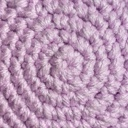

In [17]:
#@title Target image {vertical-output: true}
url = './knit.jpg'
style_img = imread(url, max_size=128)
with torch.no_grad():
  loss_f = create_vgg_loss(to_nchw(style_img))
imshow(style_img)

In [18]:
#@title setup training
ca = CA()
opt = torch.optim.Adam(ca.parameters(), 1e-3, capturable=True)
lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [1000, 2000], 0.3)
loss_log = []
with torch.no_grad():
  pool = ca.seed(256)


        step_n: 1
        loss: 5731245.5
        lr: 0.001

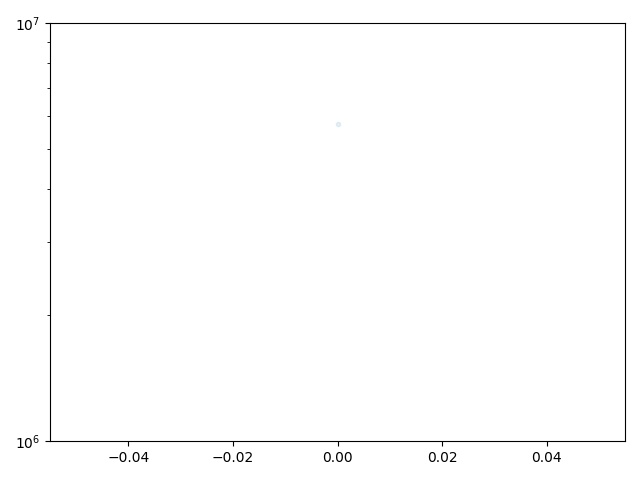

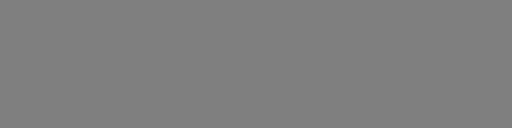


        step_n: 6
        loss: 27053442.0
        lr: 0.001


        step_n: 11
        loss: 2755585.5
        lr: 0.001


        step_n: 16
        loss: 4632863.5
        lr: 0.001


        step_n: 21
        loss: 1309447.125
        lr: 0.001


        step_n: 26
        loss: 2055515.375
        lr: 0.001


        step_n: 31
        loss: 6866375.5
        lr: 0.001


        step_n: 36
        loss: 915849.625
        lr: 0.001


        step_n: 41
        loss: 1470545.625
        lr: 0.001


        step_n: 46
        loss: 1014845.0
        lr: 0.001


        step_n: 51
        loss: 466442.90625
        lr: 0.001

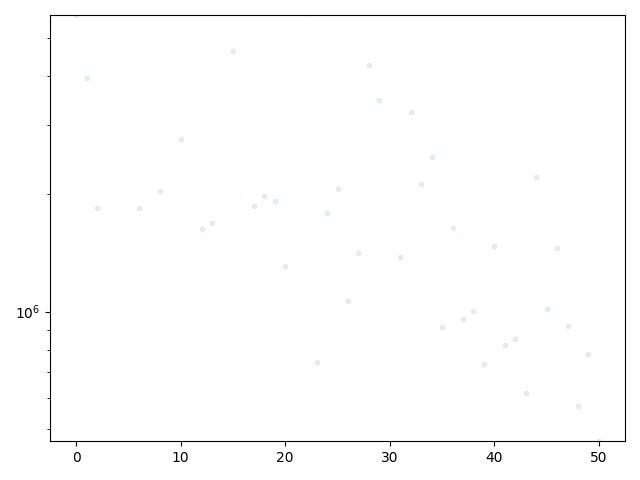

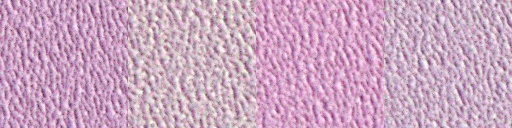


        step_n: 56
        loss: 495045.25
        lr: 0.001


        step_n: 61
        loss: 359366.65625
        lr: 0.001


        step_n: 66
        loss: 823599.75
        lr: 0.001


        step_n: 71
        loss: 499469.1875
        lr: 0.001


        step_n: 76
        loss: 527069.9375
        lr: 0.001


        step_n: 81
        loss: 664728.875
        lr: 0.001


        step_n: 86
        loss: 667444.3125
        lr: 0.001


        step_n: 91
        loss: 997368.375
        lr: 0.001


        step_n: 96
        loss: 866933.4375
        lr: 0.001


        step_n: 101
        loss: 1385537.25
        lr: 0.001

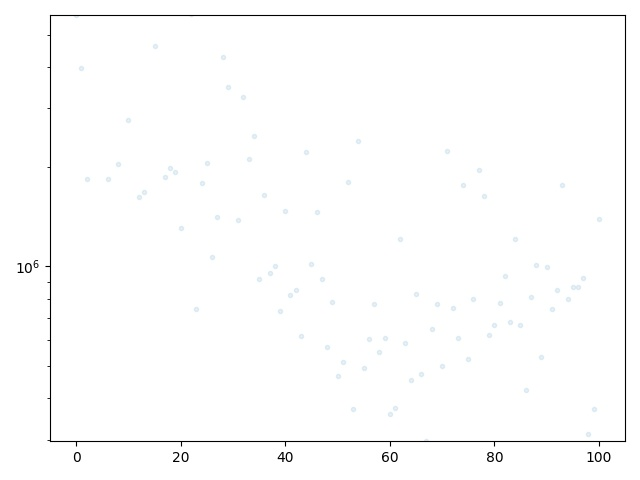

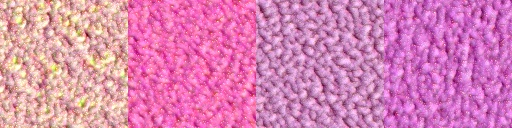


        step_n: 106
        loss: 525001.375
        lr: 0.001


        step_n: 111
        loss: 274393.125
        lr: 0.001


        step_n: 116
        loss: 310115.4375
        lr: 0.001


        step_n: 121
        loss: 980823.0
        lr: 0.001


        step_n: 126
        loss: 366251.0625
        lr: 0.001


        step_n: 131
        loss: 313063.3125
        lr: 0.001


        step_n: 136
        loss: 382101.59375
        lr: 0.001


        step_n: 141
        loss: 489133.21875
        lr: 0.001


        step_n: 146
        loss: 1274827.375
        lr: 0.001


        step_n: 151
        loss: 221127.96875
        lr: 0.001

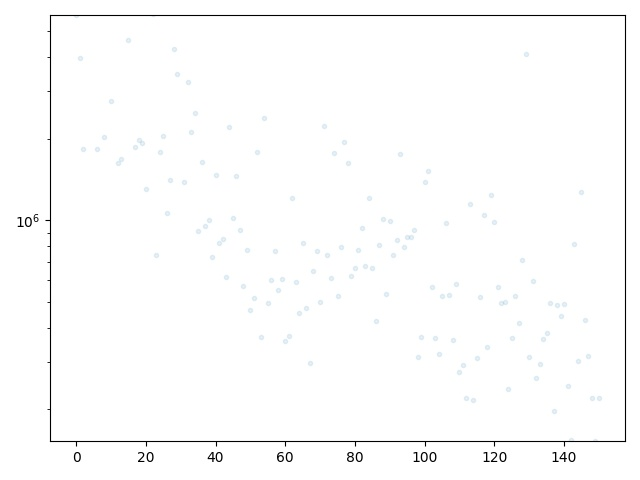

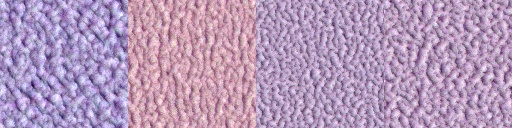


        step_n: 156
        loss: 406815.1875
        lr: 0.001


        step_n: 161
        loss: 243057.5625
        lr: 0.001


        step_n: 166
        loss: 447699.25
        lr: 0.001


        step_n: 171
        loss: 307797.46875
        lr: 0.001


        step_n: 176
        loss: 114226.40625
        lr: 0.001


        step_n: 181
        loss: 130755.4140625
        lr: 0.001


        step_n: 186
        loss: 388681.28125
        lr: 0.001


        step_n: 191
        loss: 233904.359375
        lr: 0.001


        step_n: 196
        loss: 176261.078125
        lr: 0.001


        step_n: 201
        loss: 153435.078125
        lr: 0.001

Exception ignored in: <function tqdm.__del__ at 0x0000021F6CBD89A0>
Traceback (most recent call last):
  File "c:\Users\angus\miniconda3\envs\nca\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\angus\miniconda3\envs\nca\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x0000021F6CBD89A0>
Traceback (most recent call last):
  File "c:\Users\angus\miniconda3\envs\nca\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\angus\miniconda3\envs\nca\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


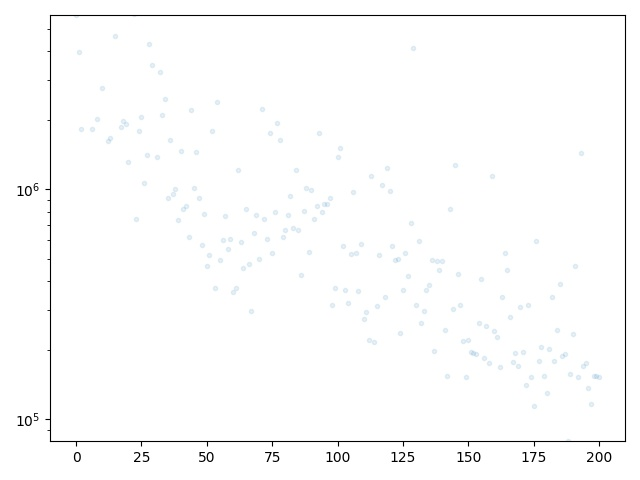

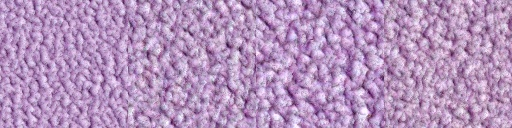


        step_n: 206
        loss: 187999.03125
        lr: 0.001


        step_n: 211
        loss: 371479.1875
        lr: 0.001


        step_n: 216
        loss: 198872.46875
        lr: 0.001


        step_n: 221
        loss: 229590.6875
        lr: 0.001


        step_n: 226
        loss: 126007.234375
        lr: 0.001


        step_n: 231
        loss: 217086.0625
        lr: 0.001


        step_n: 236
        loss: 199660.265625
        lr: 0.001


        step_n: 241
        loss: 194453.140625
        lr: 0.001


        step_n: 246
        loss: 175730.9375
        lr: 0.001


        step_n: 251
        loss: 106083.484375
        lr: 0.001

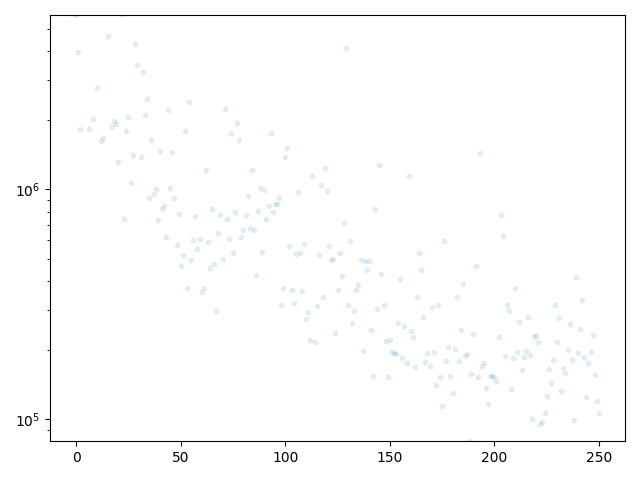

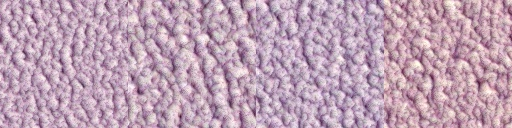


        step_n: 256
        loss: 187888.75
        lr: 0.001


        step_n: 261
        loss: 129395.2421875
        lr: 0.001


        step_n: 266
        loss: 76463.125
        lr: 0.001


        step_n: 271
        loss: 97162.71875
        lr: 0.001


        step_n: 276
        loss: 104015.7578125
        lr: 0.001


        step_n: 281
        loss: 158811.640625
        lr: 0.001


        step_n: 286
        loss: 86060.4765625
        lr: 0.001


        step_n: 291
        loss: 63351.09765625
        lr: 0.001


        step_n: 296
        loss: 70860.0546875
        lr: 0.001


        step_n: 301
        loss: 81117.09375
        lr: 0.001

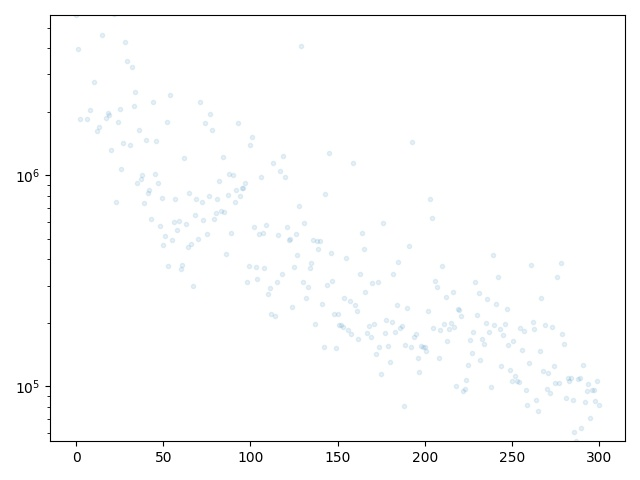

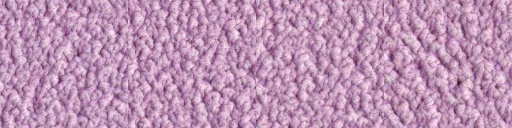


        step_n: 306
        loss: 86392.484375
        lr: 0.001


        step_n: 311
        loss: 61112.1484375
        lr: 0.001


        step_n: 316
        loss: 71768.921875
        lr: 0.001


        step_n: 321
        loss: 96275.09375
        lr: 0.001


        step_n: 326
        loss: 111139.1015625
        lr: 0.001


        step_n: 331
        loss: 56688.78515625
        lr: 0.001


        step_n: 336
        loss: 67590.75
        lr: 0.001


        step_n: 341
        loss: 84579.390625
        lr: 0.001


        step_n: 346
        loss: 49299.76953125
        lr: 0.001


        step_n: 351
        loss: 86316.984375
        lr: 0.001

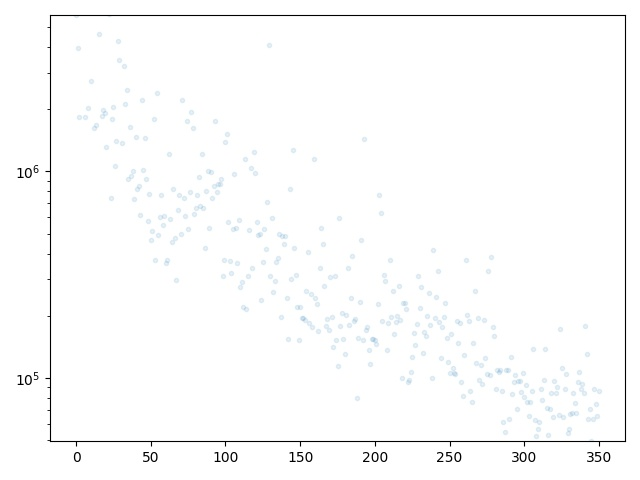

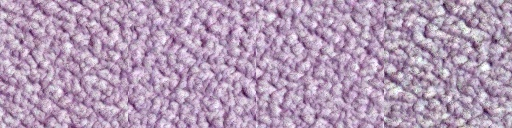


        step_n: 356
        loss: 71793.65625
        lr: 0.001


        step_n: 361
        loss: 177348.796875
        lr: 0.001


        step_n: 366
        loss: 82313.8359375
        lr: 0.001


        step_n: 371
        loss: 64643.1953125
        lr: 0.001


        step_n: 376
        loss: 51562.9921875
        lr: 0.001


        step_n: 381
        loss: 93787.3515625
        lr: 0.001


        step_n: 386
        loss: 52256.71484375
        lr: 0.001


        step_n: 391
        loss: 102952.7421875
        lr: 0.001


        step_n: 396
        loss: 77986.8203125
        lr: 0.001


        step_n: 401
        loss: 46083.03515625
        lr: 0.001

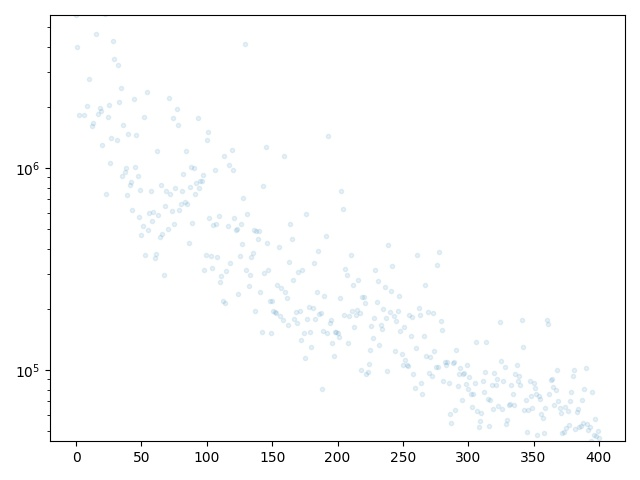

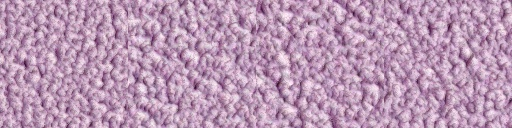


        step_n: 406
        loss: 48530.2265625
        lr: 0.001


        step_n: 411
        loss: 64073.6953125
        lr: 0.001


        step_n: 416
        loss: 61885.125
        lr: 0.001


        step_n: 421
        loss: 66367.8671875
        lr: 0.001


        step_n: 426
        loss: 47709.05859375
        lr: 0.001


        step_n: 431
        loss: 49779.4140625
        lr: 0.001


        step_n: 436
        loss: 55316.6328125
        lr: 0.001


        step_n: 441
        loss: 48386.7109375
        lr: 0.001


        step_n: 446
        loss: 43766.63671875
        lr: 0.001


        step_n: 451
        loss: 57846.15234375
        lr: 0.001

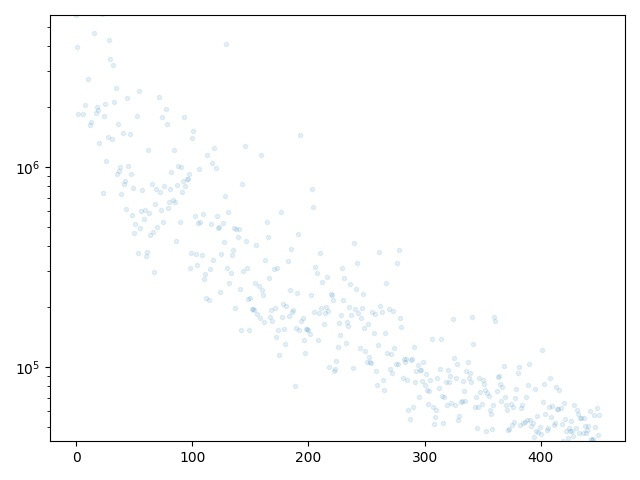

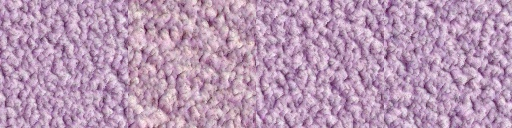


        step_n: 456
        loss: 48220.83203125
        lr: 0.001


        step_n: 461
        loss: 57509.16015625
        lr: 0.001


        step_n: 466
        loss: 47772.1640625
        lr: 0.001


        step_n: 471
        loss: 39984.66015625
        lr: 0.001


        step_n: 476
        loss: 54105.18359375
        lr: 0.001


        step_n: 481
        loss: 44082.25390625
        lr: 0.001


        step_n: 486
        loss: 52908.61328125
        lr: 0.001


        step_n: 491
        loss: 53481.98046875
        lr: 0.001


        step_n: 496
        loss: 45774.37109375
        lr: 0.001


        step_n: 501
        loss: 44225.9140625
        lr: 0.001

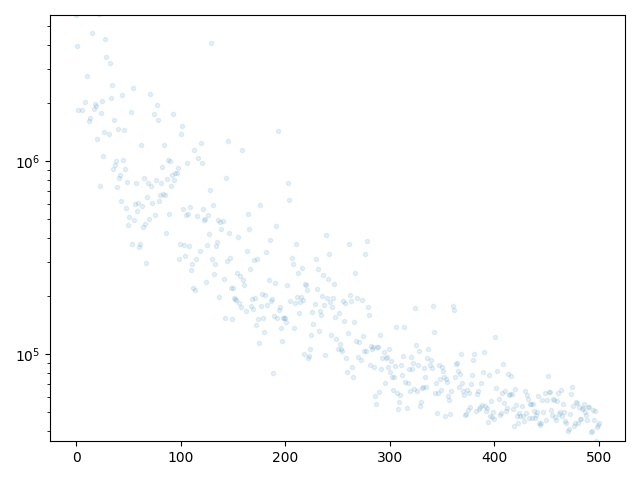

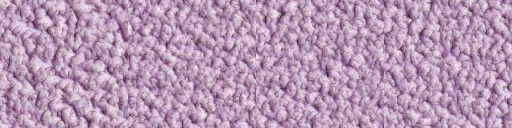


        step_n: 506
        loss: 41859.4921875
        lr: 0.001


        step_n: 511
        loss: 44492.46484375
        lr: 0.001


        step_n: 516
        loss: 34374.79296875
        lr: 0.001


        step_n: 521
        loss: 46136.59765625
        lr: 0.001


        step_n: 526
        loss: 39737.49609375
        lr: 0.001


        step_n: 531
        loss: 46153.265625
        lr: 0.001


        step_n: 536
        loss: 44946.359375
        lr: 0.001


        step_n: 541
        loss: 44206.30859375
        lr: 0.001


        step_n: 546
        loss: 40459.54296875
        lr: 0.001


        step_n: 551
        loss: 49537.96875
        lr: 0.001

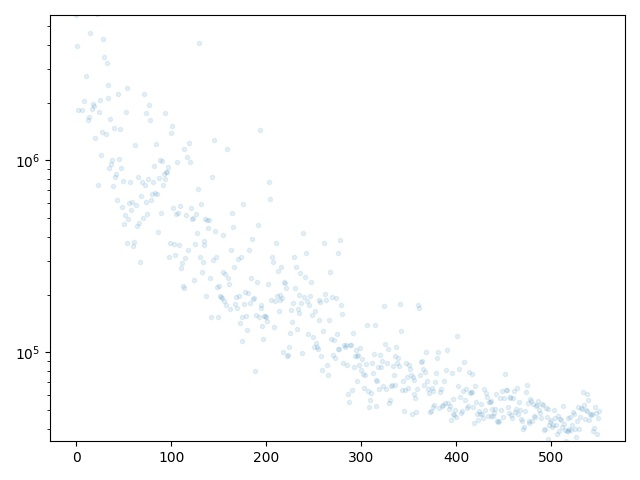

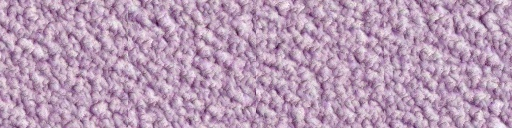


        step_n: 556
        loss: 45553.3984375
        lr: 0.001


        step_n: 561
        loss: 49081.41015625
        lr: 0.001


        step_n: 566
        loss: 35764.4765625
        lr: 0.001


        step_n: 571
        loss: 39330.6484375
        lr: 0.001


        step_n: 576
        loss: 44246.15625
        lr: 0.001


        step_n: 581
        loss: 37778.7578125
        lr: 0.001


        step_n: 586
        loss: 36200.26953125
        lr: 0.001


        step_n: 591
        loss: 38973.0546875
        lr: 0.001


        step_n: 596
        loss: 38925.65234375
        lr: 0.001


        step_n: 601
        loss: 44387.17578125
        lr: 0.001

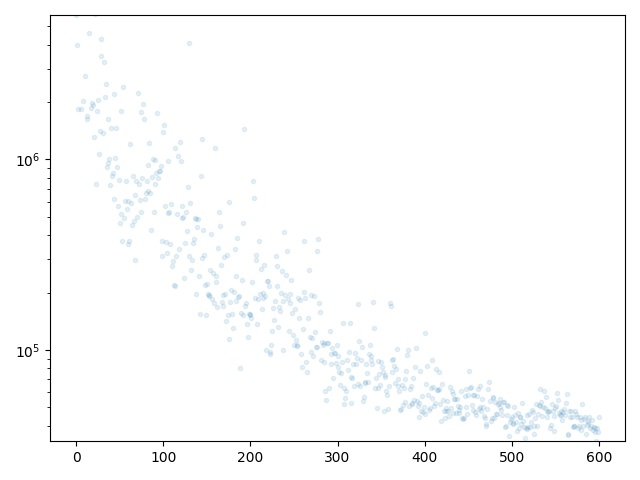

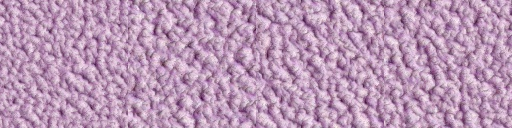


        step_n: 606
        loss: 41439.6875
        lr: 0.001


        step_n: 611
        loss: 60529.08203125
        lr: 0.001


        step_n: 616
        loss: 51741.83203125
        lr: 0.001


        step_n: 621
        loss: 48031.0390625
        lr: 0.001


        step_n: 626
        loss: 56356.17578125
        lr: 0.001


        step_n: 631
        loss: 55528.17578125
        lr: 0.001


        step_n: 636
        loss: 45156.0625
        lr: 0.001


        step_n: 641
        loss: 51032.515625
        lr: 0.001


        step_n: 646
        loss: 40937.21875
        lr: 0.001


        step_n: 651
        loss: 42840.38671875
        lr: 0.001

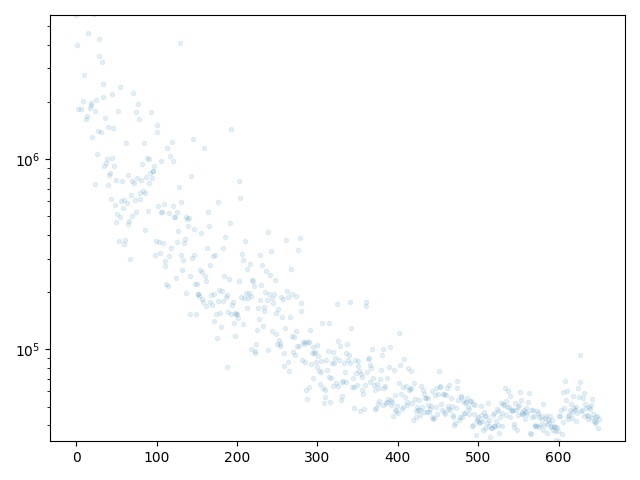

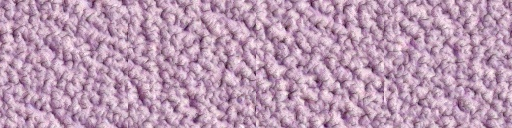


        step_n: 656
        loss: 36964.95703125
        lr: 0.001


        step_n: 661
        loss: 37078.24609375
        lr: 0.001


        step_n: 666
        loss: 32788.8515625
        lr: 0.001


        step_n: 671
        loss: 48052.44140625
        lr: 0.001


        step_n: 676
        loss: 52728.5234375
        lr: 0.001


        step_n: 681
        loss: 48927.24609375
        lr: 0.001


        step_n: 686
        loss: 41566.24609375
        lr: 0.001


        step_n: 691
        loss: 37815.54296875
        lr: 0.001


        step_n: 696
        loss: 34647.10546875
        lr: 0.001


        step_n: 701
        loss: 38751.35546875
        lr: 0.001

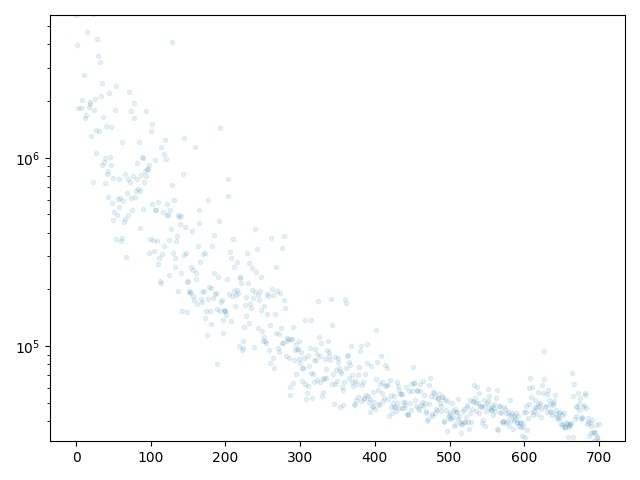

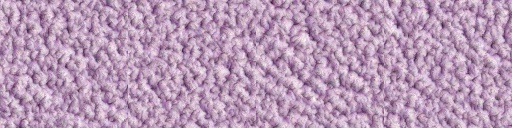


        step_n: 706
        loss: 32494.849609375
        lr: 0.001


        step_n: 711
        loss: 36792.609375
        lr: 0.001


        step_n: 716
        loss: 38271.2265625
        lr: 0.001


        step_n: 721
        loss: 52875.58984375
        lr: 0.001


        step_n: 726
        loss: 38602.0546875
        lr: 0.001


        step_n: 731
        loss: 35447.46484375
        lr: 0.001


        step_n: 736
        loss: 35364.62109375
        lr: 0.001


        step_n: 741
        loss: 33834.2890625
        lr: 0.001


        step_n: 746
        loss: 31896.99609375
        lr: 0.001


        step_n: 751
        loss: 33337.859375
        lr: 0.001

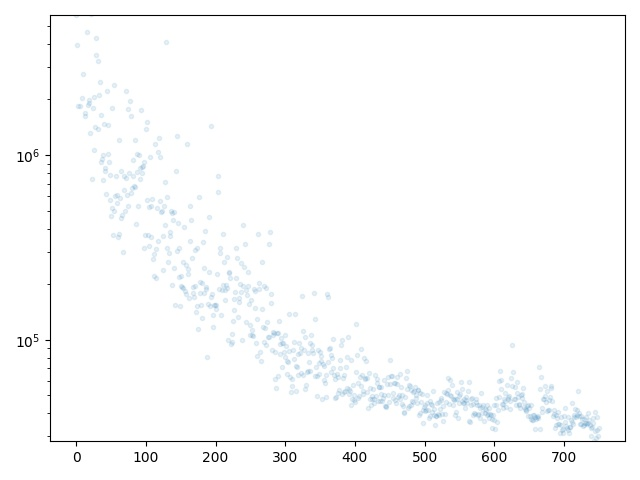

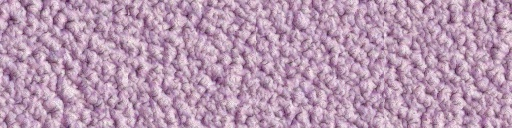


        step_n: 756
        loss: 31656.7890625
        lr: 0.001


        step_n: 761
        loss: 46741.54296875
        lr: 0.001


        step_n: 766
        loss: 39263.19140625
        lr: 0.001


        step_n: 771
        loss: 35321.3046875
        lr: 0.001


        step_n: 776
        loss: 37325.69140625
        lr: 0.001


        step_n: 781
        loss: 38896.44921875
        lr: 0.001


        step_n: 786
        loss: 37833.265625
        lr: 0.001


        step_n: 791
        loss: 33869.92578125
        lr: 0.001


        step_n: 796
        loss: 43693.03125
        lr: 0.001


        step_n: 801
        loss: 36108.2578125
        lr: 0.001

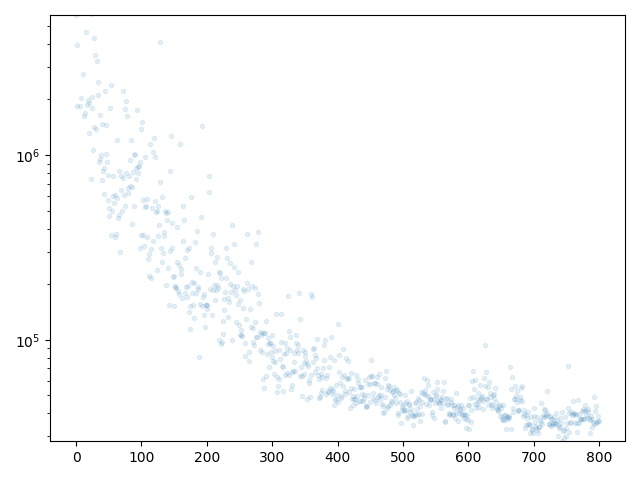

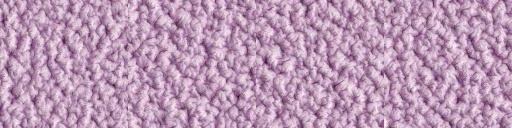


        step_n: 806
        loss: 34205.4140625
        lr: 0.001


        step_n: 811
        loss: 35016.8203125
        lr: 0.001


        step_n: 816
        loss: 42454.12890625
        lr: 0.001


        step_n: 821
        loss: 39438.40625
        lr: 0.001


        step_n: 826
        loss: 34395.15625
        lr: 0.001


        step_n: 831
        loss: 31155.66015625
        lr: 0.001


        step_n: 836
        loss: 37288.546875
        lr: 0.001


        step_n: 841
        loss: 37544.55859375
        lr: 0.001


        step_n: 846
        loss: 35445.515625
        lr: 0.001


        step_n: 851
        loss: 31114.26953125
        lr: 0.001

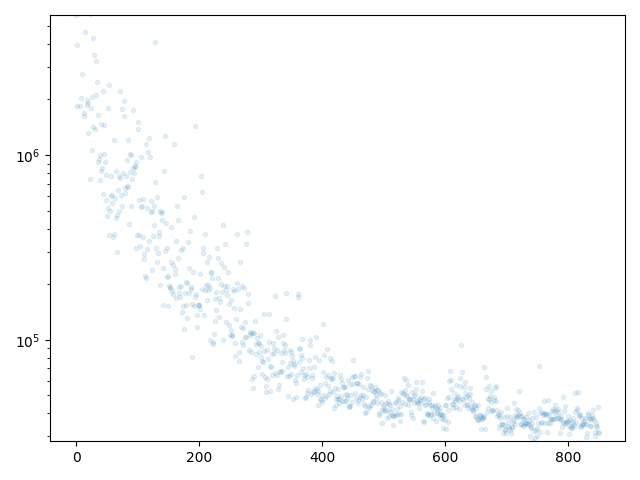

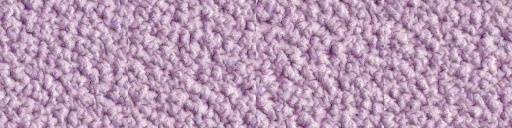


        step_n: 856
        loss: 33326.1328125
        lr: 0.001


        step_n: 861
        loss: 37477.5546875
        lr: 0.001


        step_n: 866
        loss: 33959.015625
        lr: 0.001


        step_n: 871
        loss: 32563.6640625
        lr: 0.001


        step_n: 876
        loss: 36665.5
        lr: 0.001


        step_n: 881
        loss: 46696.96875
        lr: 0.001


        step_n: 886
        loss: 31680.728515625
        lr: 0.001


        step_n: 891
        loss: 39307.5859375
        lr: 0.001


        step_n: 896
        loss: 35198.1796875
        lr: 0.001


        step_n: 901
        loss: 34042.11328125
        lr: 0.001

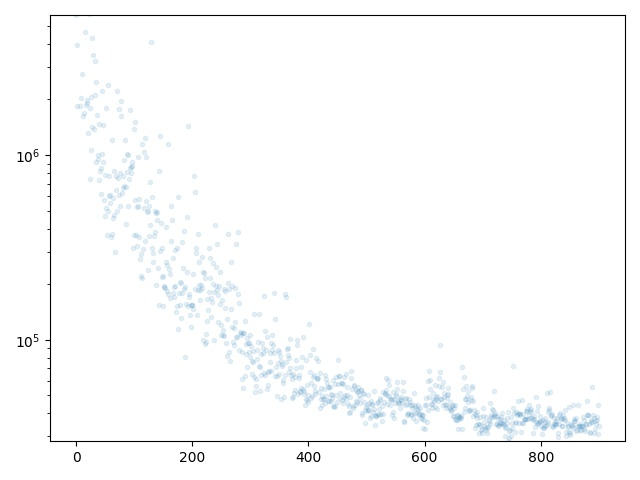

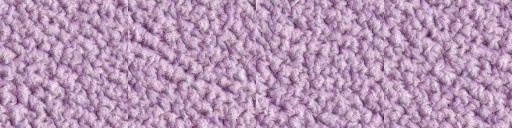


        step_n: 906
        loss: 39772.15625
        lr: 0.001


        step_n: 911
        loss: 40175.94140625
        lr: 0.001


        step_n: 916
        loss: 34030.828125
        lr: 0.001


        step_n: 921
        loss: 38718.0390625
        lr: 0.001


        step_n: 926
        loss: 30459.595703125
        lr: 0.001


        step_n: 931
        loss: 44354.39453125
        lr: 0.001


        step_n: 936
        loss: 36373.7890625
        lr: 0.001


        step_n: 941
        loss: 29694.244140625
        lr: 0.001


        step_n: 946
        loss: 34724.7421875
        lr: 0.001


        step_n: 951
        loss: 31576.650390625
        lr: 0.001

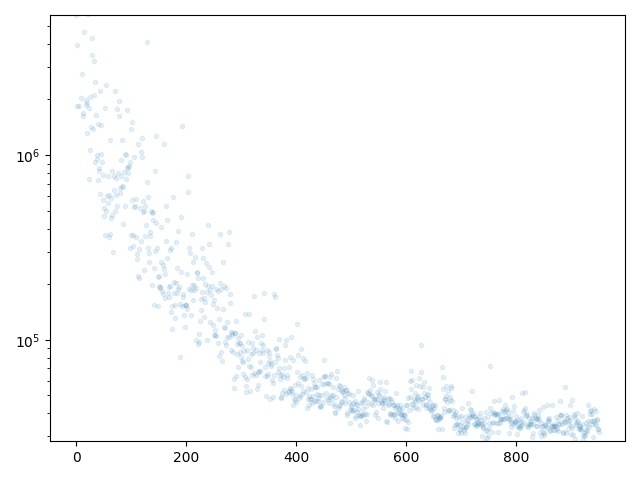

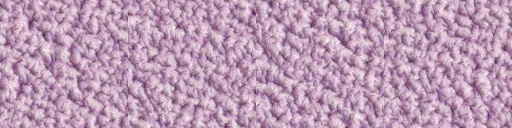


        step_n: 956
        loss: 33770.44140625
        lr: 0.001


        step_n: 961
        loss: 33469.953125
        lr: 0.001


        step_n: 966
        loss: 29779.35546875
        lr: 0.001


        step_n: 971
        loss: 29549.732421875
        lr: 0.001


        step_n: 976
        loss: 36094.28515625
        lr: 0.001


        step_n: 981
        loss: 35248.51953125
        lr: 0.001


        step_n: 986
        loss: 35585.59765625
        lr: 0.001


        step_n: 991
        loss: 38271.1171875
        lr: 0.001


        step_n: 996
        loss: 30129.720703125
        lr: 0.001


        step_n: 1001
        loss: 34334.2734375
        lr: 0.0003

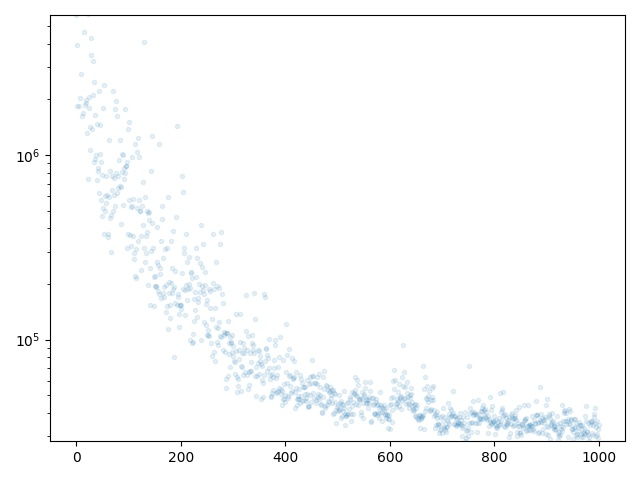

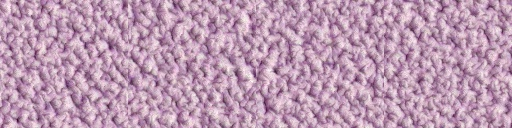


        step_n: 1006
        loss: 32638.466796875
        lr: 0.0003


        step_n: 1011
        loss: 31731.19140625
        lr: 0.0003


        step_n: 1016
        loss: 29737.69921875
        lr: 0.0003


        step_n: 1021
        loss: 29693.5703125
        lr: 0.0003


        step_n: 1026
        loss: 31140.63671875
        lr: 0.0003


        step_n: 1031
        loss: 35196.70703125
        lr: 0.0003


        step_n: 1036
        loss: 26972.59765625
        lr: 0.0003


        step_n: 1041
        loss: 31341.65625
        lr: 0.0003


        step_n: 1046
        loss: 29646.4765625
        lr: 0.0003


        step_n: 1051
        loss: 29712.1953125
        lr: 0.0003

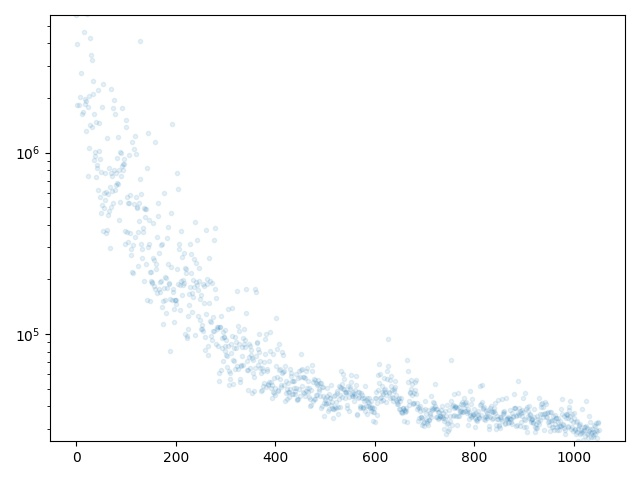

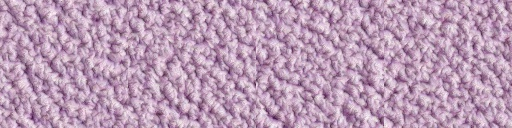


        step_n: 1056
        loss: 27969.9296875
        lr: 0.0003


        step_n: 1061
        loss: 28316.984375
        lr: 0.0003


        step_n: 1066
        loss: 27534.517578125
        lr: 0.0003


        step_n: 1071
        loss: 27923.244140625
        lr: 0.0003


        step_n: 1076
        loss: 26231.818359375
        lr: 0.0003


        step_n: 1081
        loss: 32338.09375
        lr: 0.0003


        step_n: 1086
        loss: 28150.142578125
        lr: 0.0003


        step_n: 1091
        loss: 28214.2109375
        lr: 0.0003


        step_n: 1096
        loss: 27881.265625
        lr: 0.0003


        step_n: 1101
        loss: 26464.0546875
        lr: 0.0003

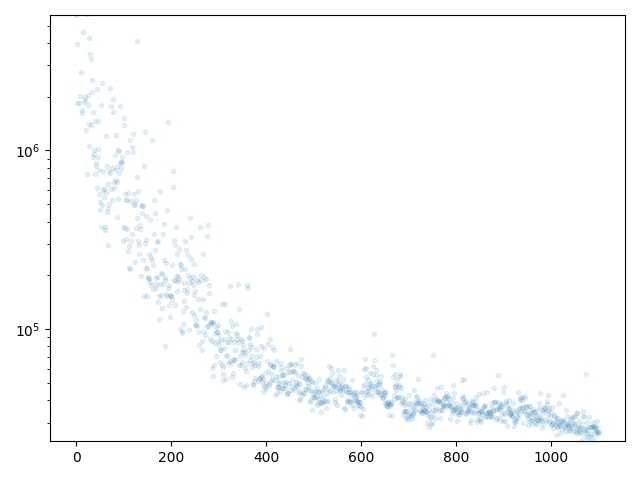

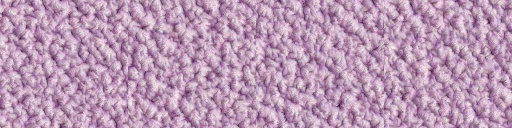


        step_n: 1106
        loss: 26162.91015625
        lr: 0.0003


        step_n: 1111
        loss: 29871.787109375
        lr: 0.0003


        step_n: 1116
        loss: 26950.265625
        lr: 0.0003


        step_n: 1121
        loss: 30623.16796875
        lr: 0.0003


        step_n: 1126
        loss: 25769.88671875
        lr: 0.0003


        step_n: 1131
        loss: 28137.837890625
        lr: 0.0003


        step_n: 1136
        loss: 27023.166015625
        lr: 0.0003


        step_n: 1141
        loss: 28354.853515625
        lr: 0.0003


        step_n: 1146
        loss: 27403.404296875
        lr: 0.0003


        step_n: 1151
        loss: 27605.751953125
        lr: 0.0003

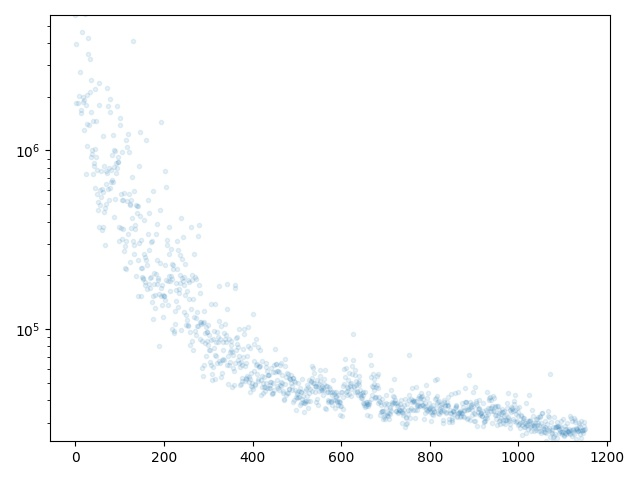

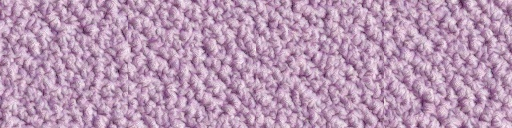


        step_n: 1156
        loss: 23479.009765625
        lr: 0.0003


        step_n: 1161
        loss: 26815.60546875
        lr: 0.0003


        step_n: 1166
        loss: 24693.158203125
        lr: 0.0003


        step_n: 1171
        loss: 25527.390625
        lr: 0.0003


        step_n: 1176
        loss: 26187.798828125
        lr: 0.0003


        step_n: 1181
        loss: 27529.71484375
        lr: 0.0003


        step_n: 1186
        loss: 28470.33984375
        lr: 0.0003


        step_n: 1191
        loss: 27652.587890625
        lr: 0.0003


        step_n: 1196
        loss: 27808.453125
        lr: 0.0003


        step_n: 1201
        loss: 29970.470703125
        lr: 0.0003

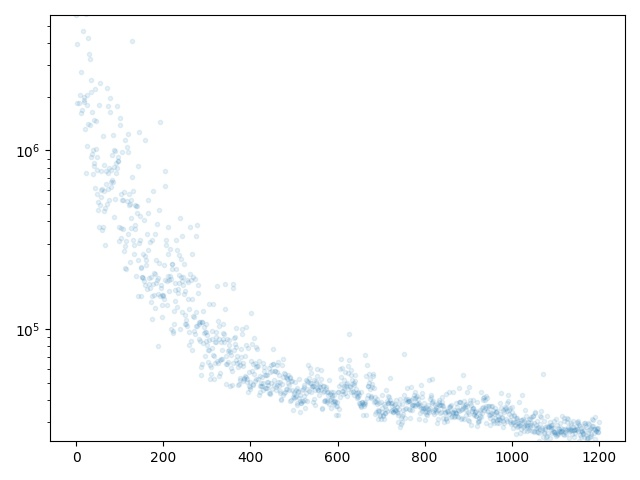

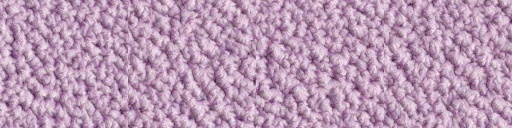


        step_n: 1206
        loss: 26285.146484375
        lr: 0.0003


        step_n: 1211
        loss: 27721.19140625
        lr: 0.0003


        step_n: 1216
        loss: 26291.23046875
        lr: 0.0003


        step_n: 1221
        loss: 25512.08984375
        lr: 0.0003


        step_n: 1226
        loss: 24923.09375
        lr: 0.0003


        step_n: 1231
        loss: 28188.109375
        lr: 0.0003


        step_n: 1236
        loss: 28583.5703125
        lr: 0.0003


        step_n: 1241
        loss: 27155.6640625
        lr: 0.0003


        step_n: 1246
        loss: 26049.4609375
        lr: 0.0003


        step_n: 1251
        loss: 28162.91796875
        lr: 0.0003

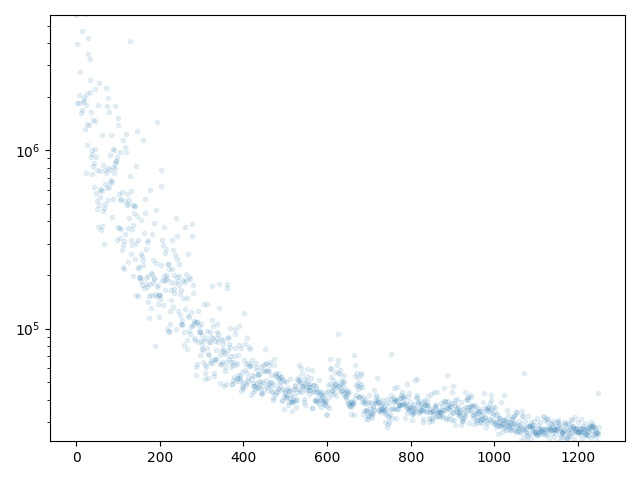

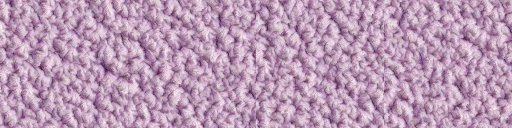


        step_n: 1256
        loss: 27391.232421875
        lr: 0.0003


        step_n: 1261
        loss: 25598.41796875
        lr: 0.0003


        step_n: 1266
        loss: 26294.19921875
        lr: 0.0003


        step_n: 1271
        loss: 26324.125
        lr: 0.0003


        step_n: 1276
        loss: 25646.796875
        lr: 0.0003


        step_n: 1281
        loss: 31786.61328125
        lr: 0.0003


        step_n: 1286
        loss: 26232.982421875
        lr: 0.0003


        step_n: 1291
        loss: 29783.232421875
        lr: 0.0003


        step_n: 1296
        loss: 27510.76953125
        lr: 0.0003


        step_n: 1301
        loss: 26081.412109375
        lr: 0.0003

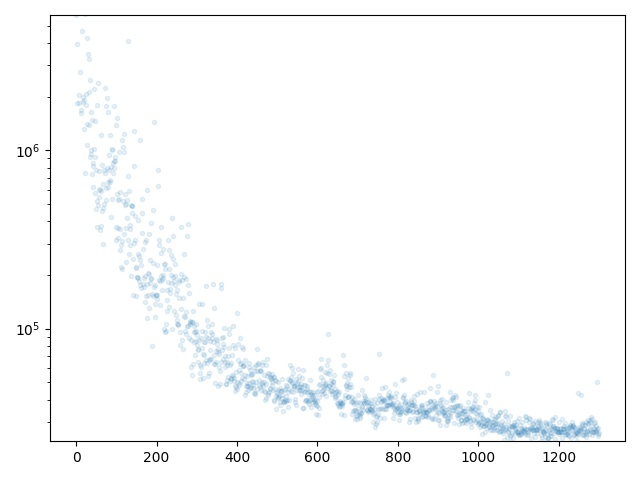

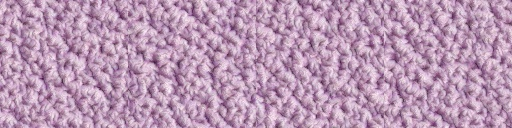


        step_n: 1306
        loss: 29367.6875
        lr: 0.0003


        step_n: 1311
        loss: 24680.4375
        lr: 0.0003


        step_n: 1316
        loss: 25813.28515625
        lr: 0.0003


        step_n: 1321
        loss: 25544.162109375
        lr: 0.0003


        step_n: 1326
        loss: 28057.671875
        lr: 0.0003


        step_n: 1331
        loss: 27549.8359375
        lr: 0.0003


        step_n: 1336
        loss: 25125.888671875
        lr: 0.0003


        step_n: 1341
        loss: 28845.8359375
        lr: 0.0003


        step_n: 1346
        loss: 28083.658203125
        lr: 0.0003


        step_n: 1351
        loss: 33481.65625
        lr: 0.0003

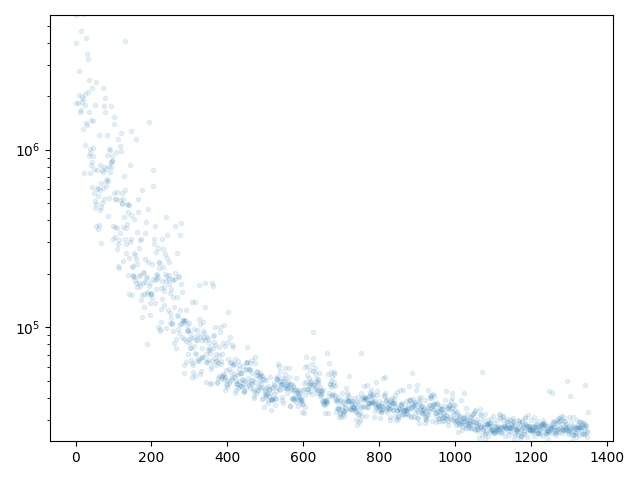

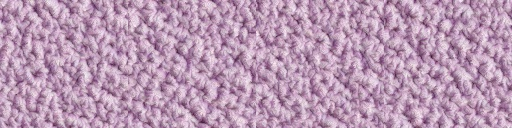


        step_n: 1356
        loss: 28490.14453125
        lr: 0.0003


        step_n: 1361
        loss: 25852.3984375
        lr: 0.0003


        step_n: 1366
        loss: 28582.578125
        lr: 0.0003


        step_n: 1371
        loss: 26540.005859375
        lr: 0.0003


        step_n: 1376
        loss: 24215.748046875
        lr: 0.0003


        step_n: 1381
        loss: 26481.07421875
        lr: 0.0003


        step_n: 1386
        loss: 26280.298828125
        lr: 0.0003


        step_n: 1391
        loss: 27128.759765625
        lr: 0.0003


        step_n: 1396
        loss: 29876.66796875
        lr: 0.0003


        step_n: 1401
        loss: 24773.59375
        lr: 0.0003

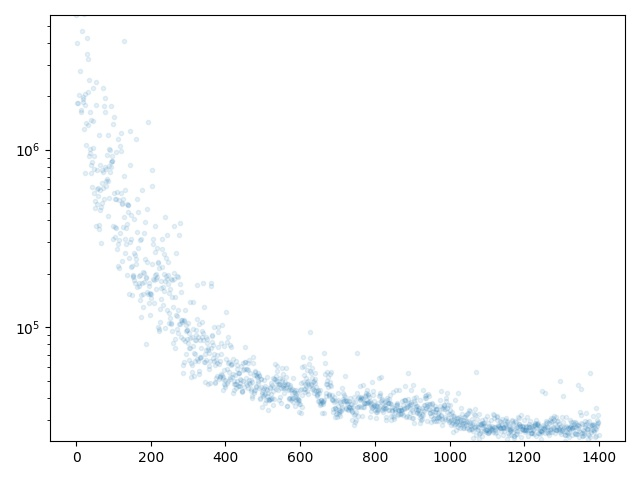

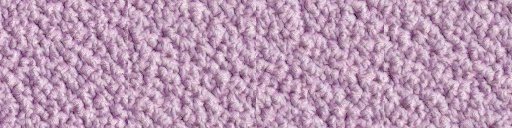


        step_n: 1406
        loss: 28212.6484375
        lr: 0.0003


        step_n: 1411
        loss: 27606.103515625
        lr: 0.0003


        step_n: 1416
        loss: 28369.35546875
        lr: 0.0003


        step_n: 1421
        loss: 26212.759765625
        lr: 0.0003


        step_n: 1426
        loss: 28114.865234375
        lr: 0.0003


        step_n: 1431
        loss: 24846.5859375
        lr: 0.0003


        step_n: 1436
        loss: 25004.255859375
        lr: 0.0003


        step_n: 1441
        loss: 24603.63671875
        lr: 0.0003


        step_n: 1446
        loss: 24022.70703125
        lr: 0.0003


        step_n: 1451
        loss: 25236.69921875
        lr: 0.0003

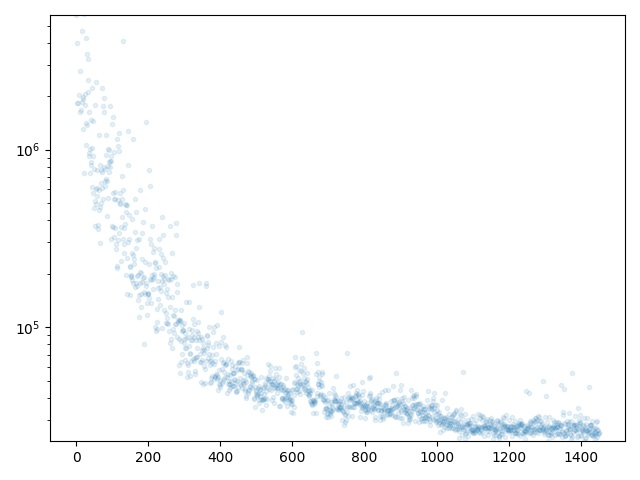

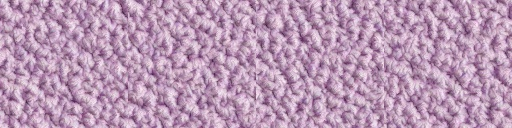


        step_n: 1456
        loss: 26533.36328125
        lr: 0.0003


        step_n: 1461
        loss: 24149.982421875
        lr: 0.0003


        step_n: 1466
        loss: 22620.8125
        lr: 0.0003


        step_n: 1471
        loss: 24910.6171875
        lr: 0.0003


        step_n: 1476
        loss: 24692.357421875
        lr: 0.0003


        step_n: 1481
        loss: 36007.36328125
        lr: 0.0003


        step_n: 1486
        loss: 24399.75390625
        lr: 0.0003


        step_n: 1491
        loss: 25954.07421875
        lr: 0.0003


        step_n: 1496
        loss: 28271.86328125
        lr: 0.0003


        step_n: 1501
        loss: 26350.244140625
        lr: 0.0003

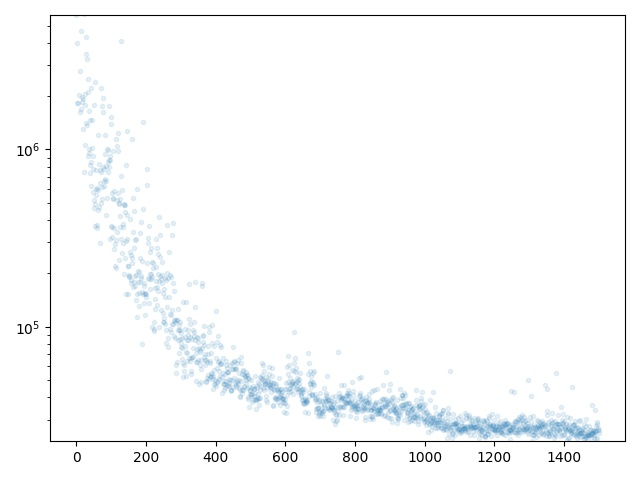

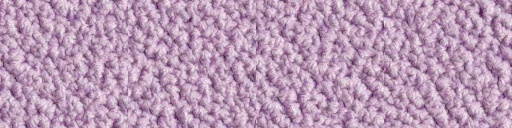


        step_n: 1506
        loss: 24380.357421875
        lr: 0.0003


        step_n: 1511
        loss: 24095.251953125
        lr: 0.0003


        step_n: 1516
        loss: 25631.78125
        lr: 0.0003


        step_n: 1521
        loss: 27783.82421875
        lr: 0.0003


        step_n: 1526
        loss: 23900.470703125
        lr: 0.0003


        step_n: 1531
        loss: 27522.87109375
        lr: 0.0003


        step_n: 1536
        loss: 23488.572265625
        lr: 0.0003


        step_n: 1541
        loss: 24610.650390625
        lr: 0.0003


        step_n: 1546
        loss: 24144.6875
        lr: 0.0003


        step_n: 1551
        loss: 23079.927734375
        lr: 0.0003

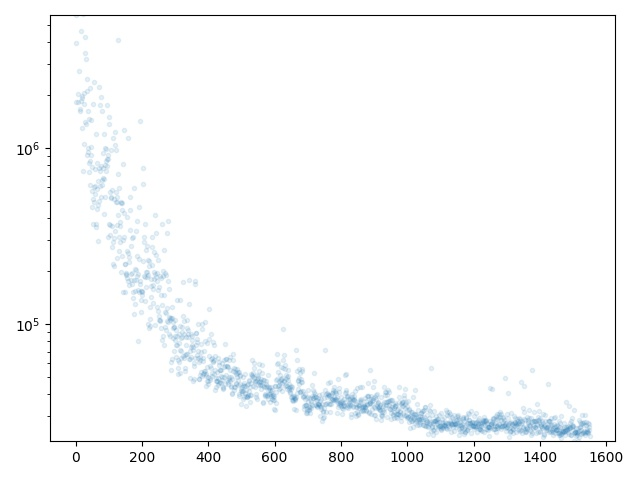

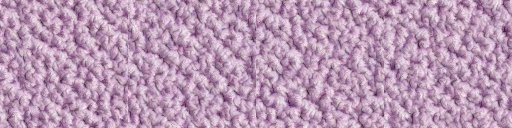


        step_n: 1556
        loss: 23990.9140625
        lr: 0.0003


        step_n: 1561
        loss: 23179.33203125
        lr: 0.0003


        step_n: 1566
        loss: 26120.24609375
        lr: 0.0003


        step_n: 1571
        loss: 24237.61328125
        lr: 0.0003


        step_n: 1576
        loss: 26217.640625
        lr: 0.0003


        step_n: 1581
        loss: 29035.4609375
        lr: 0.0003


        step_n: 1586
        loss: 27051.458984375
        lr: 0.0003


        step_n: 1591
        loss: 27552.443359375
        lr: 0.0003


        step_n: 1596
        loss: 27507.185546875
        lr: 0.0003


        step_n: 1601
        loss: 25172.259765625
        lr: 0.0003

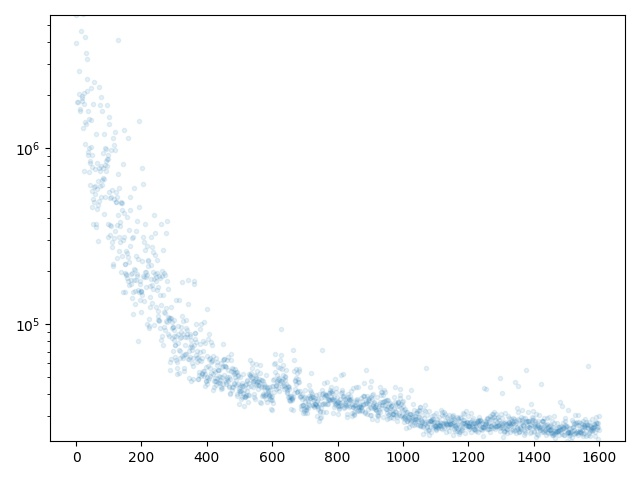

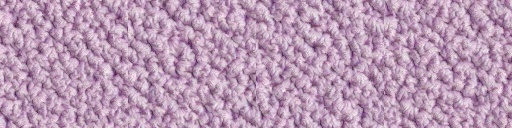


        step_n: 1606
        loss: 25229.087890625
        lr: 0.0003


        step_n: 1611
        loss: 24511.65625
        lr: 0.0003


        step_n: 1616
        loss: 27780.125
        lr: 0.0003


        step_n: 1621
        loss: 26520.185546875
        lr: 0.0003


        step_n: 1626
        loss: 27466.36328125
        lr: 0.0003


        step_n: 1631
        loss: 25003.515625
        lr: 0.0003


        step_n: 1636
        loss: 25625.875
        lr: 0.0003


        step_n: 1641
        loss: 27912.66796875
        lr: 0.0003


        step_n: 1646
        loss: 26097.9453125
        lr: 0.0003


        step_n: 1651
        loss: 24300.798828125
        lr: 0.0003

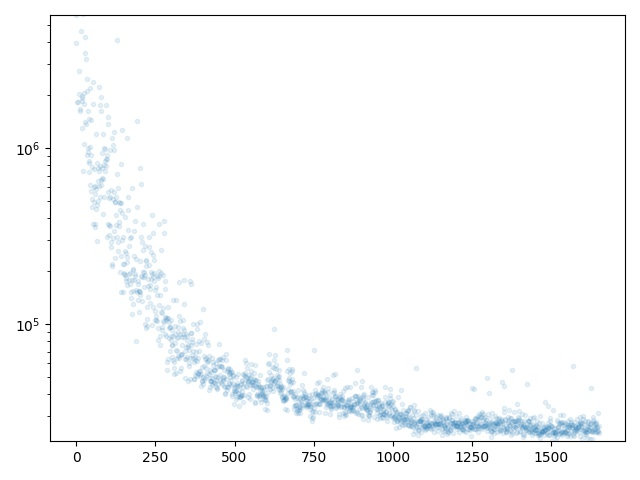

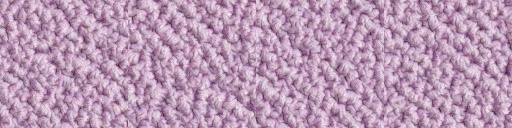


        step_n: 1656
        loss: 27280.37109375
        lr: 0.0003


        step_n: 1661
        loss: 26860.498046875
        lr: 0.0003


        step_n: 1666
        loss: 25548.861328125
        lr: 0.0003


        step_n: 1671
        loss: 28524.14453125
        lr: 0.0003


        step_n: 1676
        loss: 23701.802734375
        lr: 0.0003


        step_n: 1681
        loss: 33990.296875
        lr: 0.0003


        step_n: 1686
        loss: 24742.734375
        lr: 0.0003


        step_n: 1691
        loss: 24731.927734375
        lr: 0.0003


        step_n: 1696
        loss: 24927.41796875
        lr: 0.0003


        step_n: 1701
        loss: 23096.662109375
        lr: 0.0003

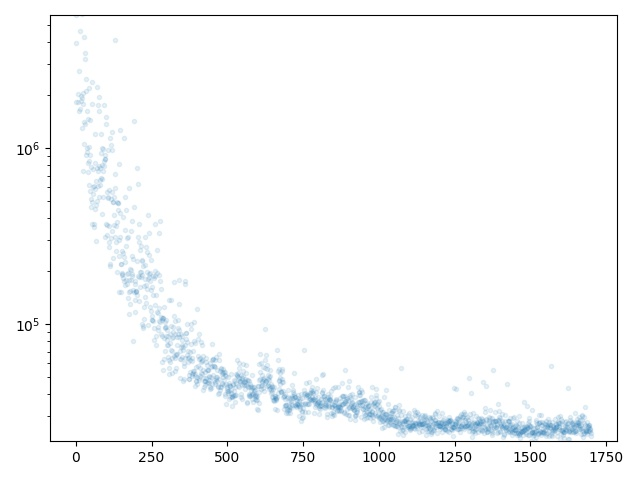

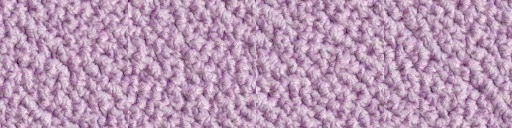


        step_n: 1706
        loss: 23544.779296875
        lr: 0.0003


        step_n: 1711
        loss: 23548.37890625
        lr: 0.0003


        step_n: 1716
        loss: 27464.0078125
        lr: 0.0003


        step_n: 1721
        loss: 26148.734375
        lr: 0.0003


        step_n: 1726
        loss: 26502.603515625
        lr: 0.0003


        step_n: 1731
        loss: 24564.66015625
        lr: 0.0003


        step_n: 1736
        loss: 25668.818359375
        lr: 0.0003


        step_n: 1741
        loss: 24833.408203125
        lr: 0.0003


        step_n: 1746
        loss: 23808.24609375
        lr: 0.0003


        step_n: 1751
        loss: 22800.029296875
        lr: 0.0003

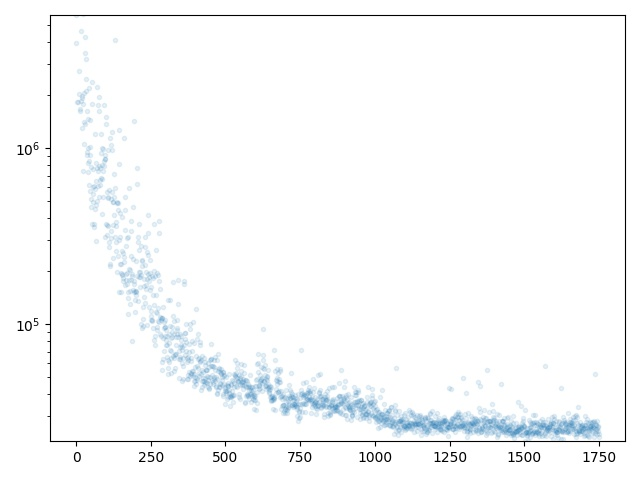

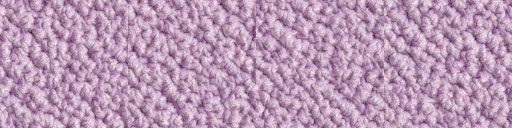


        step_n: 1756
        loss: 29288.14453125
        lr: 0.0003


        step_n: 1761
        loss: 26000.345703125
        lr: 0.0003


        step_n: 1766
        loss: 23872.33984375
        lr: 0.0003


        step_n: 1771
        loss: 25825.470703125
        lr: 0.0003


        step_n: 1776
        loss: 24526.345703125
        lr: 0.0003


        step_n: 1781
        loss: 23899.583984375
        lr: 0.0003


        step_n: 1786
        loss: 23886.26171875
        lr: 0.0003


        step_n: 1791
        loss: 27981.4765625
        lr: 0.0003


        step_n: 1796
        loss: 23278.283203125
        lr: 0.0003


        step_n: 1801
        loss: 24183.78125
        lr: 0.0003

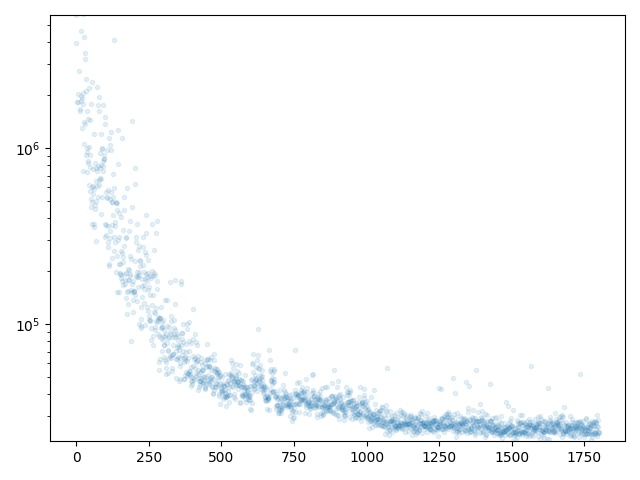

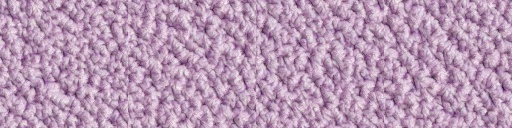


        step_n: 1806
        loss: 25596.17578125
        lr: 0.0003


        step_n: 1811
        loss: 24632.7578125
        lr: 0.0003


        step_n: 1816
        loss: 26709.08203125
        lr: 0.0003


        step_n: 1821
        loss: 26765.658203125
        lr: 0.0003


        step_n: 1826
        loss: 22261.224609375
        lr: 0.0003


        step_n: 1831
        loss: 28436.79296875
        lr: 0.0003


        step_n: 1836
        loss: 25968.96875
        lr: 0.0003


        step_n: 1841
        loss: 26231.099609375
        lr: 0.0003


        step_n: 1846
        loss: 23927.71484375
        lr: 0.0003


        step_n: 1851
        loss: 23939.7578125
        lr: 0.0003

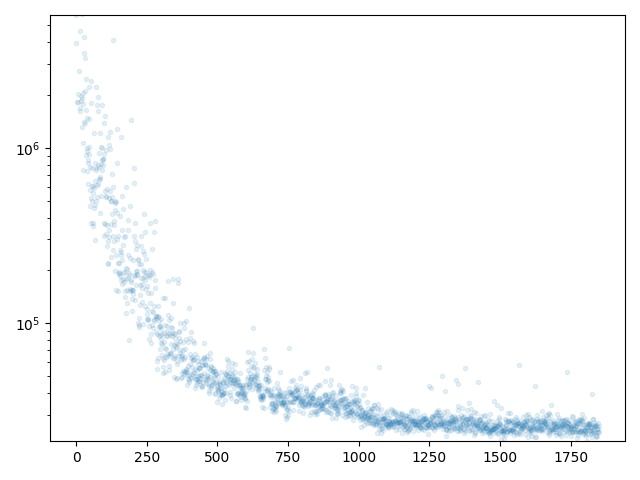

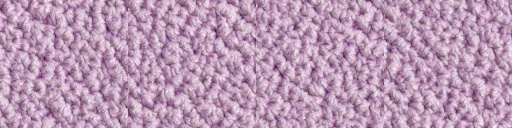


        step_n: 1856
        loss: 24112.927734375
        lr: 0.0003


        step_n: 1861
        loss: 22824.595703125
        lr: 0.0003


        step_n: 1866
        loss: 22045.806640625
        lr: 0.0003


        step_n: 1871
        loss: 24264.228515625
        lr: 0.0003


        step_n: 1876
        loss: 22851.19921875
        lr: 0.0003


        step_n: 1881
        loss: 24615.931640625
        lr: 0.0003


        step_n: 1886
        loss: 27919.19140625
        lr: 0.0003


        step_n: 1891
        loss: 25141.1015625
        lr: 0.0003


        step_n: 1896
        loss: 21872.1953125
        lr: 0.0003


        step_n: 1901
        loss: 27253.390625
        lr: 0.0003

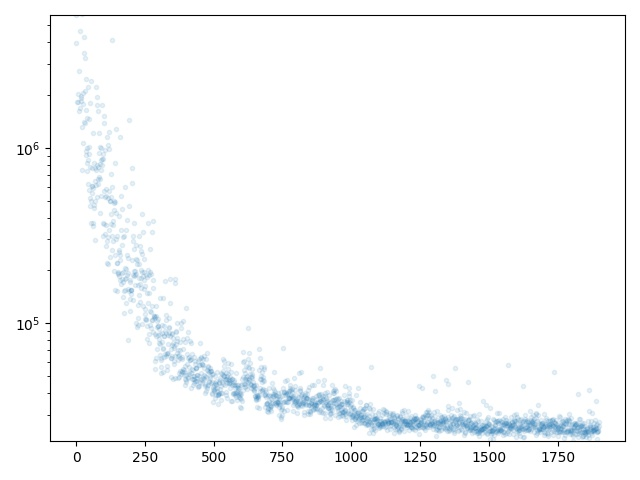

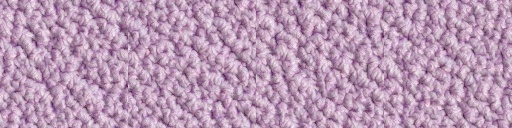


        step_n: 1906
        loss: 24154.462890625
        lr: 0.0003


        step_n: 1911
        loss: 25466.98828125
        lr: 0.0003


        step_n: 1916
        loss: 26767.126953125
        lr: 0.0003


        step_n: 1921
        loss: 34361.0078125
        lr: 0.0003


        step_n: 1926
        loss: 26801.62890625
        lr: 0.0003


        step_n: 1931
        loss: 27049.17578125
        lr: 0.0003


        step_n: 1936
        loss: 26722.478515625
        lr: 0.0003


        step_n: 1941
        loss: 24076.93359375
        lr: 0.0003


        step_n: 1946
        loss: 25761.626953125
        lr: 0.0003


        step_n: 1951
        loss: 23483.16015625
        lr: 0.0003

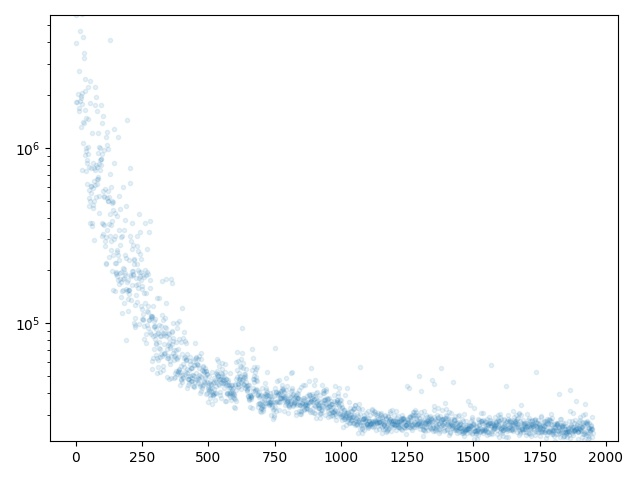

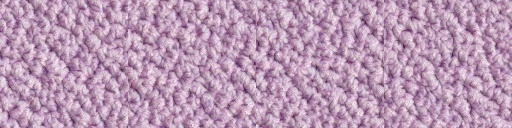


        step_n: 1956
        loss: 26135.466796875
        lr: 0.0003


        step_n: 1961
        loss: 28781.615234375
        lr: 0.0003


        step_n: 1966
        loss: 25487.23828125
        lr: 0.0003


        step_n: 1971
        loss: 26342.365234375
        lr: 0.0003


        step_n: 1976
        loss: 26064.765625
        lr: 0.0003


        step_n: 1981
        loss: 23291.533203125
        lr: 0.0003


        step_n: 1986
        loss: 26736.71875
        lr: 0.0003


        step_n: 1991
        loss: 24930.140625
        lr: 0.0003


        step_n: 1996
        loss: 23321.20703125
        lr: 0.0003

In [19]:
#@title training loop {vertical-output: true}

gradient_checkpoints = False  # Set in case of OOM problems

for i in range(2000):
  with torch.no_grad():
    batch_idx = np.random.choice(len(pool), 4, replace=False)
    x = pool[batch_idx]
    if i%8 == 0:
      x[:1] = ca.seed(1)
  step_n = np.random.randint(32, 96)
  if not gradient_checkpoints:
    for k in range(step_n):
      x = ca(x)
  else:
    x.requires_grad = True  # https://github.com/pytorch/pytorch/issues/42812
    x = torch.utils.checkpoint.checkpoint_sequential([ca]*step_n, 16, x)

  overflow_loss = (x-x.clamp(-1.0, 1.0)).abs().sum()
  loss = loss_f(to_rgb(x))+overflow_loss
  with torch.no_grad():
    loss.backward()
    for p in ca.parameters():
      p.grad /= (p.grad.norm()+1e-8)   # normalize gradients
    opt.step()
    opt.zero_grad()
    lr_sched.step()
    pool[batch_idx] = x                # update pool

    loss_log.append(loss.item())
    if i%5 == 0:
      display(Markdown(f'''
        step_n: {len(loss_log)}
        loss: {loss.item()}
        lr: {lr_sched.get_last_lr()[0]}'''), display_id='stats')
    if i%50==0:
      pl.plot(loss_log, '.', alpha=0.1)
      pl.yscale('log')
      pl.ylim(np.min(loss_log), loss_log[0])
      pl.tight_layout()
      imshow(grab_plot(), id='log')
      imgs = to_rgb(x).permute([0, 2, 3, 1]).cpu()
      imshow(np.hstack(imgs), id='batch')

In [20]:
#@title NCA video {vertical-output: true}
with VideoWriter(filename='nca_output.mp4') as vid, torch.no_grad():
  x = ca.seed(1, 256)
  for k in range(300):
    step_n = min(2**(k//30), 8)
    for i in range(step_n):
      x[:] = ca(x)
    img = to_rgb(x[0]).permute(1, 2, 0).cpu()
    vid.add(zoom(img, 2))